In [5]:
!pip install jax
!pip install jaxlib==0.4.7
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 MB 4.8 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.25
    Uninstalling jaxlib-0.3.25:
      Successfully uninstalled jaxlib-0.3.25


In [2]:
!pip install transformers

In [3]:
!pip install tensorflow

In [1]:
import tensorflow as tf
import numpy as np
import sklearn
from sklearn import metrics
import transformers
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import json
import matplotlib.pyplot as plt
import random
import seaborn as sn
import os

### 1. INSTANTIATE THE TPU
The model has been trained using Colab free TPUs. TPUs will allow us to train our model much faster and will also allow us to use a larger batch size.

In [2]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size=32 * tpu_strategy.num_replicas_in_sync
print('Batch size:', batch_size)
AUTOTUNE = tf.data.experimental.AUTOTUNE

Batch size: 256


## Sample data

{'category': 'WELLNESS',
 'headline': 'Flu Outbreak Still Widespread In U.S., But Starting To Ease, CDC Reports',
 'authors': 'Reuters, Reuters',
 'link': 'https://www.huffingtonpost.com/entry/flu-outbreak-us-starting-to-ease_us_5b9cbbf5e4b03a1dcc81545b',
 'short_description': 'Despite continued reports of spot shortages, Frieden said it is not too late to get vaccinated. (Reporting by Julie Steenhuysen',
 'date': '2013-01-18'}

In [3]:
data = []

for line in open('News_Category_Dataset_v3.json', 'r'):
  try:
    data.append(json.loads(str(line)))
  except:
    pass


In [4]:
#Load data from json file

random.shuffle(data) #shuffle the data
labels=[]
headlines=[]
texts=[]
for line in data:
    if line['category'] in ["WELLNESS","ENTERTAINMENT","POLITICS","TRAVEL","PARENTING"]:
      labels.append(line['category'])
      headlines.append(line['headline'])
      #Combine headline and description into a single text input
      text=line['headline']+' '+line['short_description']
      texts.append(text)

In [5]:
n_elements = len(texts)
n_elements

56545

In [6]:
len(texts)

56545

In [7]:
texts[0]

"Rep Calls For More Than 'Moment Of Silence' In Congress For Charleston "

[]

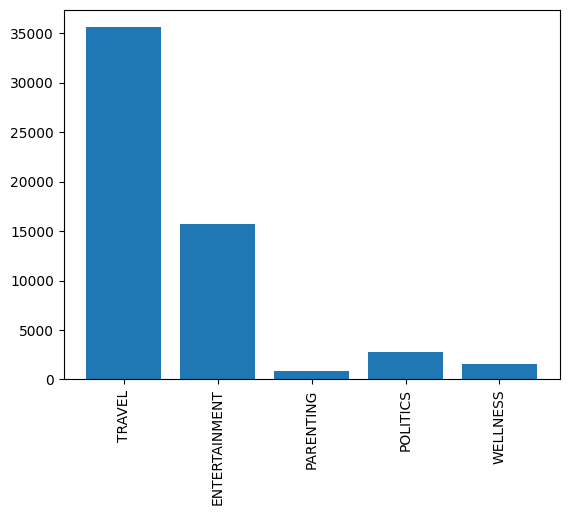

In [8]:
from collections import Counter

y_vals = Counter(labels).values()
plt.bar(list(set(labels)), list(y_vals))
plt.xticks(rotation=90)
plt.plot()

## DATA PREPROCESSING
We have now to preprocess our data in a way that can be used by a Tensorflow Keras model. As a first step, we need to turn the classes labels into indices. We don’t need a one-hot encoding since we will work with TensorFlow SparseCategorical loss.

In [9]:
categories=sorted(list(set(labels))) #set will return the unique different entries
n_categories=len(categories)

def indicize_labels(labels):
    """Transforms string labels into indices"""
    indices=[]
    for j in range(len(labels)):
        for i in range(n_categories):
            if labels[j]==categories[i]:
                indices.append(i)
    return indices

In [10]:
set(labels)

{'ENTERTAINMENT', 'PARENTING', 'POLITICS', 'TRAVEL', 'WELLNESS'}

In [11]:
indices=indicize_labels(labels) #Integer label indices
set(indices), len(indices)

({0, 1, 2, 3, 4}, 56545)

Next, we need to tokenize the text i.e. we need to transform our strings into a list of indices that can be fed to the model. The transformers library provides us the AutoTokenizer class that allows loading the pre-trained tokenizer used for RoBERTa.

RoBERTa uses a byte-level BPE tokenizer that performs subword tokenization, i.e. unknown rare words are split into common subwords present in the vocabulary. We will see what this means in examples.

In [12]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='tf') #Tokenized text

**Here the flag padding=True will pad the sentence to the max length passed in the batch. On the other side, truncation=True will truncate the sentences to the maximum number of tokens the model can accept (512 for RoBERTa, as for BERT).**

## Let’s visualize how the text gets tokenized.

In [13]:
tokens=tokenizer(texts[0:3], padding=True, truncation=True)['input_ids']
for i in range(3):
  print('Input:',texts[i])
  print('Subword tokenization:',tokenizer.tokenize(texts[i]))
  print('Indices:', tokens[i],"\n")

Input: Rep Calls For More Than 'Moment Of Silence' In Congress For Charleston 
Subword tokenization: ['Rep', 'ĠCalls', 'ĠFor', 'ĠMore', 'ĠThan', "Ġ'", 'Mom', 'ent', 'ĠOf', 'ĠSilence', "'", 'ĠIn', 'ĠCongress', 'ĠFor', 'ĠCharleston', 'Ġ']
Indices: [0, 22026, 24513, 286, 901, 15446, 128, 29390, 1342, 1525, 33992, 108, 96, 1148, 286, 12118, 1437, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

Input: HuffPost Rise: What You Need To Know On July 8 Welcome to the HuffPost Rise Morning Newsbrief, a short wrap-up of the news to help you start your day.
Subword tokenization: ['H', 'uff', 'Post', 'ĠRise', ':', 'ĠWhat', 'ĠYou', 'ĠNeed', 'ĠTo', 'ĠKnow', 'ĠOn', 'ĠJuly', 'Ġ8', 'ĠWelcome', 'Ġto', 'Ġthe', 'ĠHuffPost', 'ĠRise', 'ĠMorning', 'ĠNews', 'b', 'rief', ',', 'Ġa', 'Ġshort', 'Ġwrap', '-', 'up', 'Ġof', 'Ġthe', 'Ġnews', 'Ġto', 'Ġhelp', 'Ġyou', 'Ġstart', 'Ġyour', 'Ġday', '.']
Indices: [0, 725, 5865, 21585, 20644, 35, 653, 370, 10145, 598, 10690, 374, 550, 290, 14826, 7, 5, 24

**We see that the character 'Ġ' is used to indicate the start of a new word in the text, while the other parts of the words that get split don't contain it. For example 'Obama's' gets split into 'ĠObama', "'s". We further notice that the tokenize uses the index 0 to indicate the beginning of the text and 2 to indicate the ending. Index 1 is reserved for padding.**

As the last step in our data preprocessing, we create a TensorFlow dataset from our data and we use the first 10% of the data for validation.

In [14]:
dataset=tf.data.Dataset.from_tensor_slices((dict(inputs), indices)) #Create a tensorflow dataset
#train test split, we use 10% of the data for validation
val_data_size=int(0.1*n_elements)
val_ds=dataset.take(val_data_size).batch(batch_size, drop_remainder=True)
train_ds=dataset.skip(val_data_size).batch(batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
n_categories

5

## LOADING THE MODEL AND TRAINING
Now that we have preprocessed the data, we need to instantiate the model. We will use the Hugging Face TensorFlow auto class for sequence classification. Using the method from_pretrained, setting num_labels equal to the number of classes in our dataset, this class will take care of all the dirty work for us. It will download the pre-trained RoBERTa weights and instantiate a Keras model with a classification head on top. We can thus use all the usual Keras methods such as compile, fit and save_weights. We fine-tune our model for 6 epochs with a small learning rate 1e-5 and clipnorm=1. to limit potentially big gradients that could destroy the features learned during pretraining.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/6
198/198 [==============================] - 212s 572ms/step - loss: 0.3866 - sparse_categorical_accuracy: 0.8865 - Sparse_Top_3_Categorical_Accuracy: 0.9807 - val_loss: 0.1457 - val_sparse_categorical_accuracy: 0.9553 - val_Sparse_Top_3_Categorical_Accuracy: 0.9972
Epoch 2/6
198/198 [==============================] - 105s 528ms/step - loss: 0.1362 - sparse_categorical_accuracy: 0.9595 - Sparse_Top_3_Categorical_Accuracy: 0.9976 - val_loss: 0.1345 - val_sparse_categorical_accuracy: 0.9577 - val_Sparse_Top_3_Categorical_Accuracy: 0.9979
Epoch 3/6
198/198 [==============================] - 105s 529ms/step - loss: 0.1058 - sparse_categorical_accuracy: 0.9681 - Sparse_Top_3_Categorical_Accuracy: 0.9987 - val_loss: 0.1255 - val_sparse_categorical_accuracy: 0.9608 - val_Sparse_Top_3_Categorical_Accuracy: 0.9980
Epoch 4/6
198/198 [==============================] - 105s 532ms/step - loss: 0.0867 - sparse_categorical_accuracy: 0.9745 - Sparse_Top_3_Categorical_Accuracy: 0.9990 - val_los

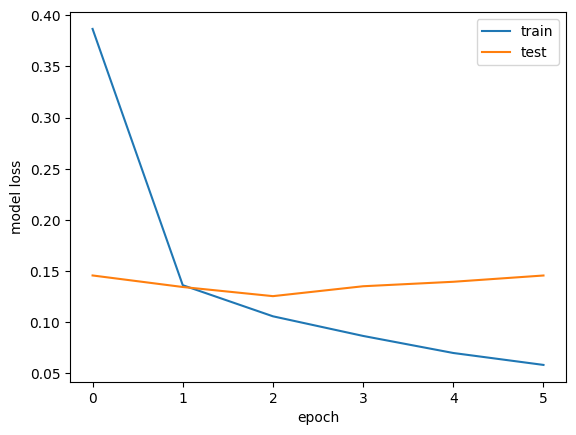

In [16]:
with tpu_strategy.scope():
    model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='Sparse_Top_3_Categorical_Accuracy')],
        )

history=model.fit(train_ds, validation_data=val_ds, epochs=6, verbose=1)

model.save_weights('./saved_weights.h5')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [17]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=n_categories)
trained_model.load_weights('./saved_weights.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

## EVALUATION
The model reach ~77% top-1-accuracy and ~93% top-3-accuracy on the validation set out of a total of 28 classes.

Let’s visualize the confusion matrix on the validation set

In [18]:
set(labels)

{'ENTERTAINMENT', 'PARENTING', 'POLITICS', 'TRAVEL', 'WELLNESS'}

In [23]:
labels=[]
texts=[]
headlines=[]
descriptions=[]
for i in range(val_data_size):
  if data[i]['category'] in ["WELLNESS","ENTERTAINMENT","POLITICS","TRAVEL","PARENTING"]:
    labels.append(data[i]['category'])
    headline=data[i]['headline']
    headlines.append(headline)
    description=data[i]['short_description']
    descriptions.append(description)
    texts.append(headline+' '+description)
labels=indicize_labels(labels)
tokens=tokenizer(texts, padding=True,truncation=True, return_tensors='tf')
logits=model.predict(dict(tokens), verbose=1).logits
prob=tf.nn.softmax(logits, axis=1).numpy()
predictions=np.argmax(prob, axis=1)
confusion_matrix=tf.math.confusion_matrix(labels, predictions, num_classes=n_categories)

73/73 [==============================] - 4s 37ms/step


<Axes: >

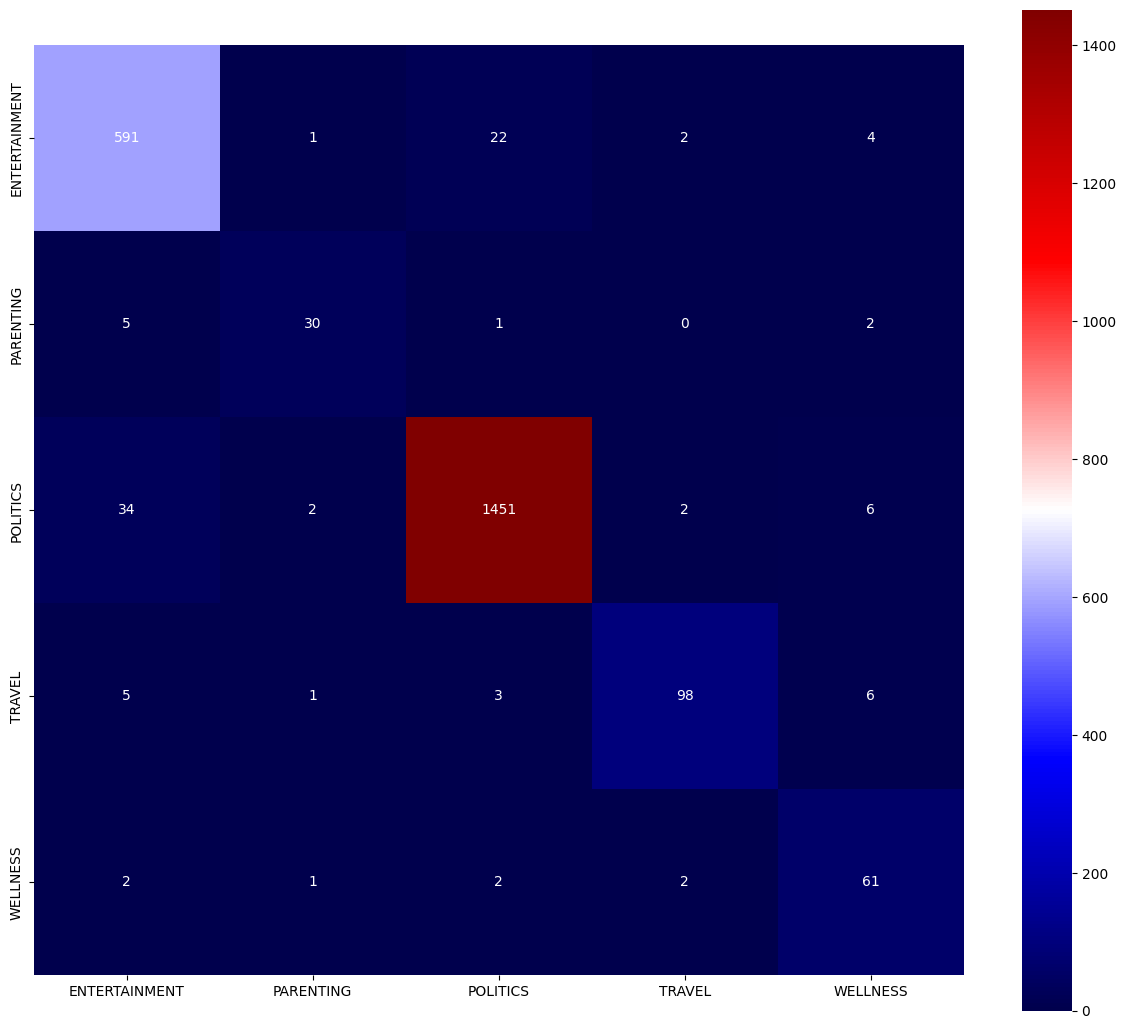

In [24]:
import seaborn as sn
plt.figure(figsize=(15,13))
sn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='seismic', square=True, xticklabels=categories, yticklabels=categories)

In [25]:
precision=metrics.precision_score(labels, predictions, average='weighted')
recall=metrics.recall_score(labels, predictions, average='weighted')
f1=metrics.f1_score(labels, predictions, average='weighted')
print('Precision:{}, Recall:{}, F1 score:{}.'.format(precision, recall, f1))

Precision:0.9569336971120912, Recall:0.9558697514995715, F1 score:0.9561037910660429.
